In [1]:
# based on https://github.com/chkwon/TrafficAssignment.jl

include(joinpath("/home/jzh/Dropbox/Research/",
"Data-driven_estimation_inverse_optimization", 
"Experiments/InverseVIsTraffic/Julia_files/load_network_uni-class.jl"))

using Graphs

function create_graph(start_node, end_node)
    @assert Base.length(start_node)==Base.length(end_node)

    no_node = max(maximum(start_node), maximum(end_node))
    no_arc = Base.length(start_node)

    graph = simple_inclist(no_node)
    for i=1:no_arc
        add_edge!(graph, start_node[i], end_node[i])
    end
    return graph
end

function get_vector(state, origin, destination, link_dic)
    current = destination
    parent = -1
    x = zeros(Int, maximum(link_dic))

    while parent != origin
        parent = state.parents[current]

        link_idx = link_dic[parent,current]

        if link_idx != 0
            x[link_idx] = 1
        end

        current = parent
    end

    return x
end

ta_data = load_ta_network("East_Massachusetts_Apr_MD")

# unpacking data from ta_data
network_name = ta_data.network_name

number_of_zones = ta_data.number_of_zones
number_of_nodes = ta_data.number_of_nodes
first_thru_node = ta_data.first_thru_node
number_of_links = ta_data.number_of_links

start_node = ta_data.start_node
end_node = ta_data.end_node
capacity = ta_data.capacity
link_length = ta_data.link_length

free_flow_time = ta_data.free_flow_time
B = ta_data.B
power = ta_data.power
speed_limit = ta_data.speed_limit
toll = ta_data.toll
link_type = ta_data.link_type
number_of_zones = ta_data.number_of_zones
total_od_flow = ta_data.total_od_flow
travel_demand = ta_data.travel_demand
od_pairs = ta_data.od_pairs

toll_factor = ta_data.toll_factor
distance_factor = ta_data.distance_factor

best_objective = ta_data.best_objective

# preparing a graph
graph = create_graph(start_node, end_node)
link_dic = sparse(start_node, end_node, 1:number_of_links);

In [2]:
function MSA(coeffs) 
    polyEval(coeffs, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)]) 

    function BPR(x)
        bpr = similar(x)
        for i=1:length(bpr)
            bpr[i] = free_flow_time[i] * polyEval( coeffs, (x[i]/capacity[i]) ) 
        end
        return bpr
    end

    function all_or_nothing(travel_time)
        state = []
        path = []
        x = zeros(size(start_node))

        for r=1:size(travel_demand)[1]
            # for each origin node r, find shortest paths to all destination nodes
            state = dijkstra_shortest_paths(graph, travel_time, r)

            for s=1:size(travel_demand)[2]
                # for each destination node s, find the shortest-path vector
                # load travel demand
                x = x + travel_demand[r,s] * get_vector(state, r, s, link_dic)
            end
        end

        return x
    end

    # Finding a starting feasible solution
    travel_time = BPR(zeros(number_of_links))
    xl = all_or_nothing(travel_time)

    max_iter_no = 1e3
    l = 1
    #average_excess_cost = 1
    tol = 1e-5

    while l < max_iter_no
        l += 1

        xl_old = xl

        # Finding yl
        travel_time = BPR(xl)

        yl = all_or_nothing(travel_time)

        xl = xl + (yl - xl)/l

        xl_new = xl

        relative_gap = norm(xl_new - xl_old, 1) / norm(xl_new, 1)

        if relative_gap < tol
            break
        end
    end
    
    return xl
end

MSA (generic function with 1 method)

In [1]:
# getting the coefficients of the costs
coeffs_dict_Apr_MD = readall("../temp_files/coeffs_dict_Apr_MD.json")
coeffs_dict_Apr_MD = JSON.parse(coeffs_dict_Apr_MD)

Dict{UTF8String,Any} with 720 entries:
  "(7,2.5,10000.0,3)" => {1.0,0.026508434549360527,0.019026974950925313,0.00846…
  "(5,0.5,100.0,3)"   => {1.0,0.009050363530470524,0.024152572480543682,0.02722…
  "(6,1.5,10.0,3)"    => {1.0,0.021304257946142772,0.02095896483299509,0.015049…
  "(6,2.0,0.1,2)"     => {1.0,0.0893381322482338,-0.1488365439524752,0.06212112…
  "(4,0.5,1000.0,1)"  => {1.0,0.013190297688232568,0.022715363444720034,0.01777…
  "(6,2.0,0.01,1)"    => {1.0,0.11605607015037543,-0.28710304839897927,0.278512…
  "(8,1.5,0.01,1)"    => {1.0,0.1290966082037129,-0.35848974301192743,0.3551066…
  "(5,1.5,1.0,1)"     => {1.0,0.0388186291576365,-0.0033325669610092513,-0.0088…
  "(8,2.5,0.001,2)"   => {1.0,0.17681163641481654,-0.7053136167768409,1.0866256…
  "(4,2.0,0.1,1)"     => {1.0,0.059388061905712705,-0.054260196205745286,0.0094…
  "(5,1.0,1000.0,2)"  => {1.0,0.0174179352836005,0.019512657485350818,0.0118085…
  "(4,2.0,0.1,2)"     => {1.0,0.059388061905712705,-0.0542601962057452

In [3]:
xl = Dict{(Int64,Float64,Float64,Int64),Array{Float64,1}}()

deg_grid = [4:8]
c_grid = .5:.5:3.
lamb_grid = [10. .^(-3:4)]

for deg in deg_grid
    for c in c_grid
        for lam in lamb_grid
            coeffs_1 = coeffs_dict_Apr_MD["($(deg),$(c),$(lam),1)"]
            coeffs_2 = coeffs_dict_Apr_MD["($(deg),$(c),$(lam),2)"]
            coeffs_3 = coeffs_dict_Apr_MD["($(deg),$(c),$(lam),3)"]
            xl[(deg, c, lam, 1)] = MSA(coeffs_1)
            xl[(deg, c, lam, 2)] = MSA(coeffs_2)
            xl[(deg, c, lam, 3)] = MSA(coeffs_3)
        end
    end
end

In [4]:
lamb_grid

8-element Array{Float64,1}:
     0.001
     0.01 
     0.1  
     1.0  
    10.0  
   100.0  
  1000.0  
 10000.0  

In [5]:
outfile = open("../temp_files/uni-class_traffic_assignment_MSA_flows_Apr_MD.json", "w")

JSON.print(outfile, xl)

close(outfile)

In [6]:
xl

Dict{(Int64,Float64,Float64,Int64),Array{Float64,1}} with 720 entries:
  (8,2.5,10.0,3)    => [11107.790194000001,2469.222299,0.0,7966.568875,11107.79…
  (4,1.0,0.01,2)    => [11107.790194000001,2469.222299,0.0,7966.568875,11107.79…
  (4,3.0,0.001,1)   => [11107.790194000001,2469.222299,0.0,7966.568875,11107.79…
  (8,2.0,1000.0,3)  => [11107.790194000001,2469.222299,0.0,7966.568875,11107.79…
  (6,1.5,0.1,1)     => [11107.790194000001,2469.222299,0.0,7966.568875,11107.79…
  (6,1.5,100.0,1)   => [11107.790194000001,2469.222299,0.0,7966.568875,11107.79…
  (4,2.0,1000.0,3)  => [11107.790194000001,2469.222299,0.0,7966.568875,11107.79…
  (5,2.5,10.0,1)    => [11107.790194000001,2469.222299,0.0,7966.568875,11107.79…
  (7,0.5,1.0,3)     => [11107.790194000001,2469.222299,0.0,7966.568875,11107.79…
  (5,0.5,100.0,2)   => [11107.790194000001,2469.222299,0.0,7966.568875,11107.79…
  (7,1.5,1.0,3)     => [11107.790194000001,2469.222299,0.0,7966.568875,11107.79…
  (4,0.5,0.01,1)    => [11107.79019400

In [7]:
xl[(8,2.5,0.1,2)]

24-element Array{Float64,1}:
 11107.8 
  2469.22
     0.0 
  7966.57
 11107.8 
  3186.78
  5265.2 
  4901.11
 10838.3 
 13503.0 
  4532.1 
  3857.81
  5152.01
  4352.55
  5231.84
  3947.25
  4793.37
  3937.57
 16037.1 
 14429.9 
  4001.46
  1048.39
  4711.72
  4487.64

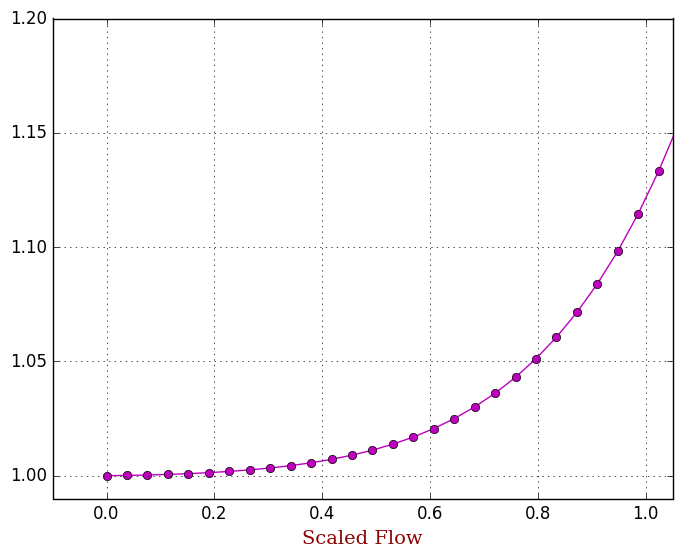

In [4]:
using PyPlot

fcoeffs = coeffs_dict_Apr_MD["(7,0.5,1000.0,1)"]

polyEval(coeffs, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)]) 

xs = linspace(0, 1.1, 30)
ys = map(x->polyEval(fcoeffs, x), xs)

plot(xs, ys, "o-m", label="Apr_MD")

#legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.05);
ylim(0.99, 1.2);

font1 = ["family"=>"serif",
    "color"=>"darkred",
    "weight"=>"normal",
    "size"=>14]
xlabel("Scaled Flow", fontdict=font1)

savefig("../temp_files/fitting_Apr_MD.pdf")